# Coffee Data Notebook

Looking at different aspects of the data, mostly to improve collection and have more awareness.


In [13]:
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from optpresso.data.partition import find_test_paths

In [18]:
DATA_DIR = os.path.expanduser("~/coffee-images/")

INPUT_SIZE = (640, 480)

images_by_time = defaultdict(list)
for time, img_path in find_test_paths(DATA_DIR):
    images_by_time[time].append(img_path)

Spread of all data in /home/badisa/coffee-images/


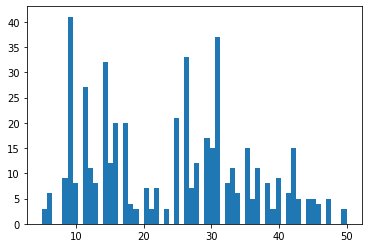

In [19]:
hist_data = []
for key, val in images_by_time.items():
    for _ in range(len(val)):
        hist_data.append(key)
plt.hist(hist_data, 60)
print(f"Spread of all data in {DATA_DIR}")

In [ ]:
plt.histo